In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
data_dir=r'C:\Users\hzhao\Desktop\python\net\celebA dataset\img_align_celeba'
part_dir=r'C:\Users\hzhao\Desktop\python\net\celebA dataset\list_eval_partition.txt'
identity_dir=r'C:\Users\hzhao\Desktop\python\net\celebA dataset\identity_CelebA.txt'
attr_dir=r'C:\Users\hzhao\Desktop\python\net\celebA dataset\list_attr_celeba.txt'

In [3]:
import os
with open(identity_dir, 'r') as f:
    lines = f.readlines()
    img_list = [os.path.join(data_dir, i.split()[0]) for i in lines]
    label_list = [i.split()[1] for i in lines]
with open(part_dir, 'r') as f:
    lines = f.readlines()
    part_list = [i.split()[1] for i in lines]
with open(attr_dir, 'r') as f:
    lines = f.readlines()
    lines=lines[2:]
    attr_list=[i.split()[21] for i in lines]

In [4]:
print(len(img_list))
print(len(label_list))
print(len(part_list))
print(len(attr_list))

202599
202599
202599
202599


In [5]:
transform=transforms.Compose(
    [transforms.Resize(224),
     transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [6]:
from PIL import Image

def default_loader(img):
    return Image.open(img)

class train_set(Dataset):
    def __init__(self):
        self.img_list=[]
        self.label_list=[]
        self.loader=default_loader
        for i in range(len(img_list)):
            if int(part_list[i])==0 and int(label_list[i])<2000:
                self.img_list.append(img_list[i])
                self.label_list.append(int(label_list[i]))
    def __getitem__(self,index):
        img_path=self.img_list[index]
        label=self.label_list[index]
        img=self.loader(img_path)
        img=transform(img)
        return img,label
    def __len__(self):
        return len(self.label_list)

In [7]:
class test_set(Dataset):
    def __init__(self):
        self.img_list=[]
        self.label_list=[]
        self.loader=default_loader
        for i in range(len(img_list)):
            if int(part_list[i])==1 and int(label_list[i])<2000:
                self.img_list.append(img_list[i])
                self.label_list.append(int(label_list[i]))
    def __getitem__(self,index):
        img_path=self.img_list[index]
        label=self.label_list[index]
        img=self.loader(img_path)
        img=transform(img)
        
        return img,label
    def __len__(self):
        return len(self.label_list)

In [8]:
train_dataset=train_set()
test_dataset=test_set()
train_loader=DataLoader(train_dataset,batch_size=4)
test_loader=DataLoader(test_dataset,batch_size=4)
print(len(train_dataset))
print(len(test_dataset))

33889
8362


<class 'torch.Tensor'>
torch.Size([3, 224, 224])
<class 'torch.Tensor'>
tensor([ 612, 1854,  667,  181])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


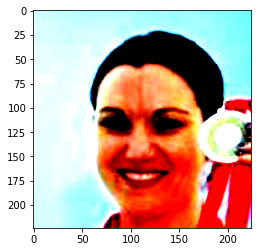

In [10]:
import matplotlib.pyplot as plt
import numpy as np

idata=iter(train_loader)
imgs,labels=idata.next()
print(type(imgs))
print(imgs[0].size())
print(type(labels))
print(labels)

plt.imshow(np.transpose(imgs[2].numpy(),[1,2,0]))

In [64]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
EPOCHS=5

cuda


In [12]:
#DEVICE=torch.device("cpu")

from MobileNetV2 import MobileNetV2
net = MobileNetV2(n_class=2)
model= MobileNetV2(n_class=2).to(DEVICE)

In [14]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace)
        (3): Conv2d(96

)


In [65]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if(batch_idx+1)%500 == 0: 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [66]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # 将一批的损失相加
            pred = output.max(1, keepdim=True)[1] # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [67]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch: 1 [1996/33889 (6%)]	Loss: 0.027390
Train Epoch: 1 [3996/33889 (12%)]	Loss: 0.579106
Train Epoch: 1 [5996/33889 (18%)]	Loss: 0.158184
Train Epoch: 1 [7996/33889 (24%)]	Loss: 0.119751
Train Epoch: 1 [9996/33889 (29%)]	Loss: 0.083363
Train Epoch: 1 [11996/33889 (35%)]	Loss: 0.192974
Train Epoch: 1 [13996/33889 (41%)]	Loss: 0.971478
Train Epoch: 1 [15996/33889 (47%)]	Loss: 0.639724
Train Epoch: 1 [17996/33889 (53%)]	Loss: 0.036810
Train Epoch: 1 [19996/33889 (59%)]	Loss: 0.071411
Train Epoch: 1 [21996/33889 (65%)]	Loss: 0.041060
Train Epoch: 1 [23996/33889 (71%)]	Loss: 0.046476
Train Epoch: 1 [25996/33889 (77%)]	Loss: 0.183942
Train Epoch: 1 [27996/33889 (83%)]	Loss: 0.029070
Train Epoch: 1 [29996/33889 (89%)]	Loss: 0.107307
Train Epoch: 1 [31996/33889 (94%)]	Loss: 0.007571

Test set: Average loss: 0.0358, Accuracy: 7867/8362 (94%)



KeyboardInterrupt: 

In [33]:
torch.__version__

'1.1.0'

In [68]:
PATH=r'C:\Users\hzhao\Desktop\python\net\pytorch-mobilenet-v2-master\demo_dict.pt'
torch.save(model.state_dict(), PATH)

In [69]:
PATH=r'C:\Users\hzhao\Desktop\python\net\pytorch-mobilenet-v2-master\demo_full.pt'
torch.save(model, PATH)